<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
#Установка библиотеки imbalanced-learn
!pip install imbalanced-learn

     |████████████████████████████████| 199 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 47 kB/s s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
#Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

In [3]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.pipeline import make_pipeline


In [4]:
RANDOM_STATE = 12345

In [5]:
#Чтение данных из файла
df = pd.read_csv("/datasets/Churn.csv")

In [6]:
#Посмотрим, как выглядят данные
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [7]:
#Информация о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [9]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [10]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [11]:
#Описание числовых признаков
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [12]:
#Посмотрим nan
df.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [13]:
#Избавимся от nan в столбце Tenure + сразу изменим тип данных столбца
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())
df['Tenure'] = df['Tenure'].astype('int')

In [14]:
#Проверим еще раз распределения
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [15]:
#Проверим, что тип изменился и нет null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


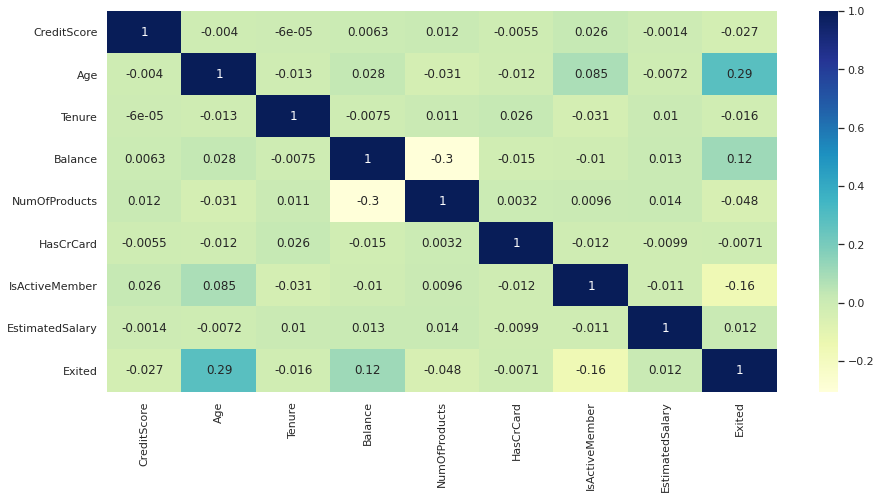

In [16]:
#Посмотрим на корреляцию признаков
sns.set(rc = {'figure.figsize':(15,7)})
f_plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)  
plt.show()

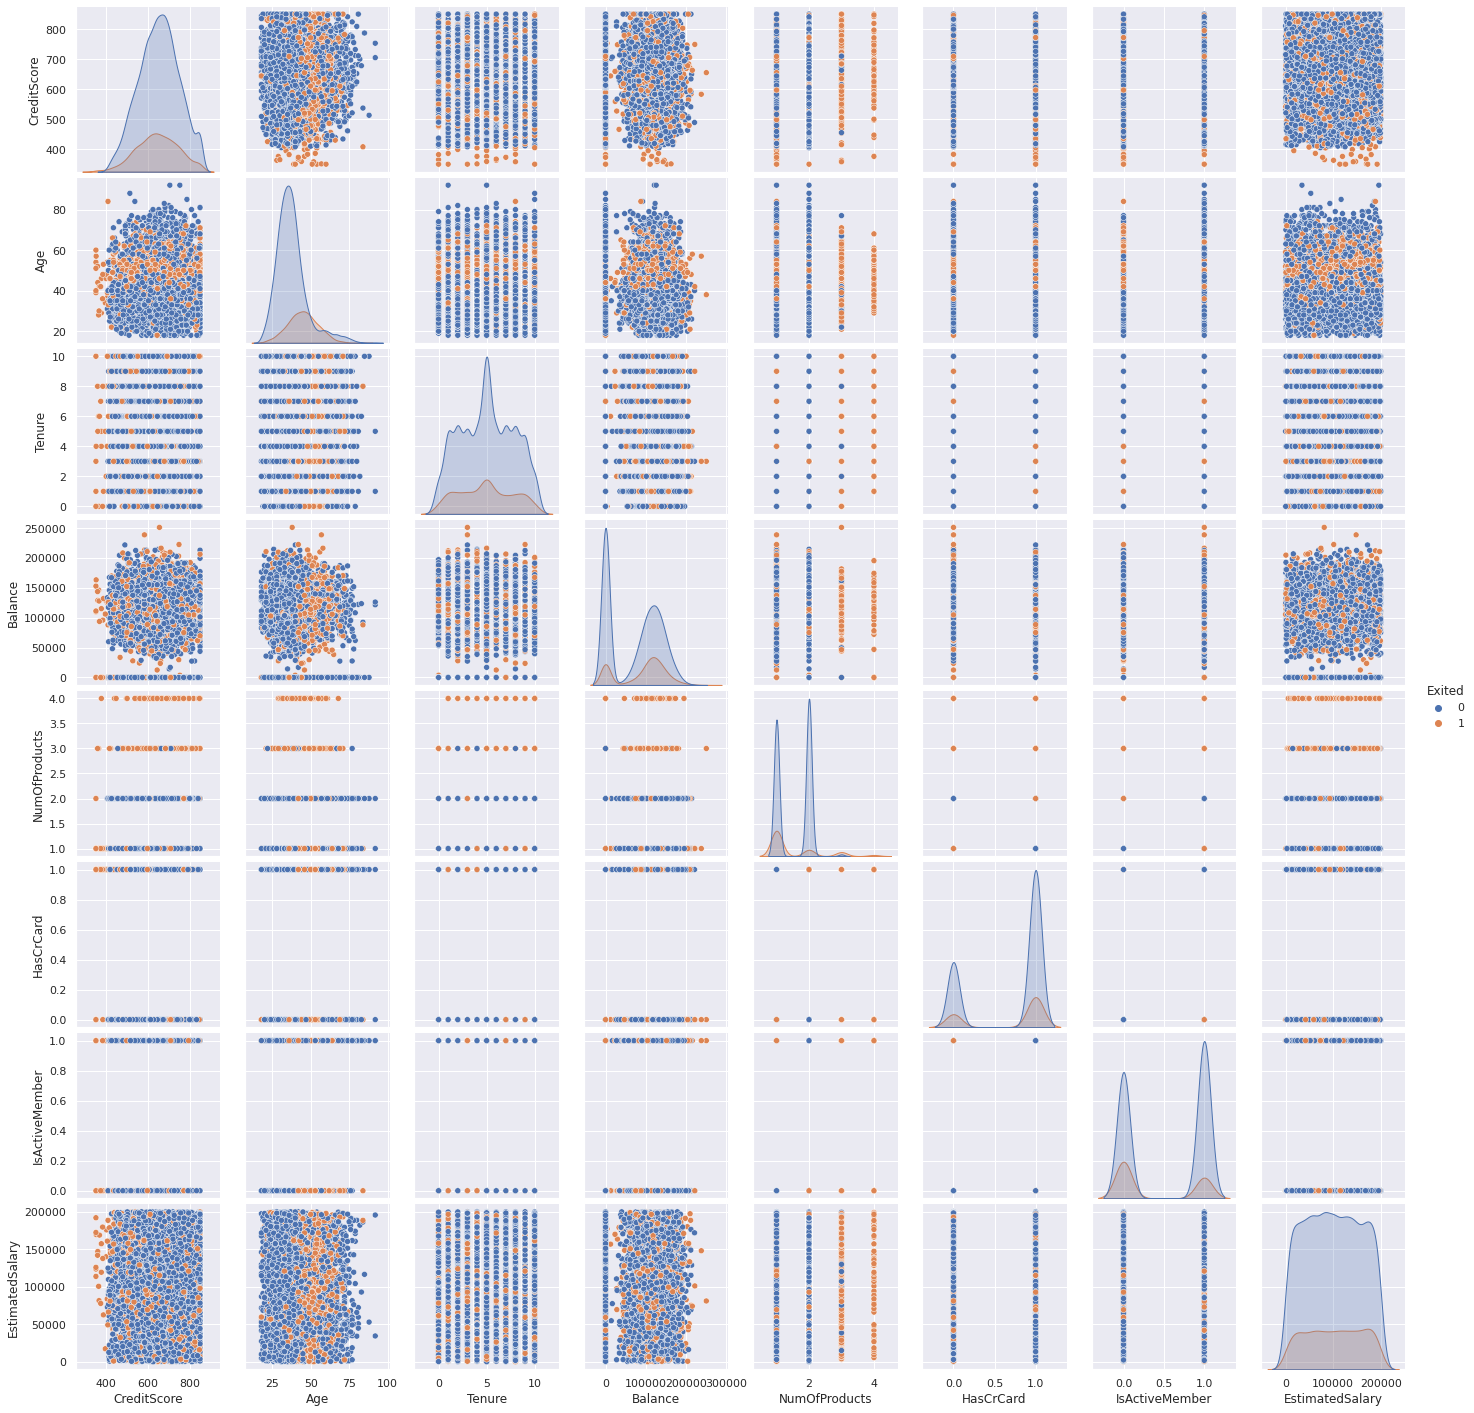

In [17]:
#Посторим pairplot, с подсвеченным целевым признаком
sns.pairplot(df, hue="Exited");

In [18]:
#Проверим дубликаты в данных
df.duplicated().sum()

0

In [19]:
#Далее в текстовых проверим какие есть значения, чтобы исключить неявные дубликаты.
#Проверим пол и географию
df.Gender.unique()

array(['Female', 'Male'], dtype=object)

In [20]:
df.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

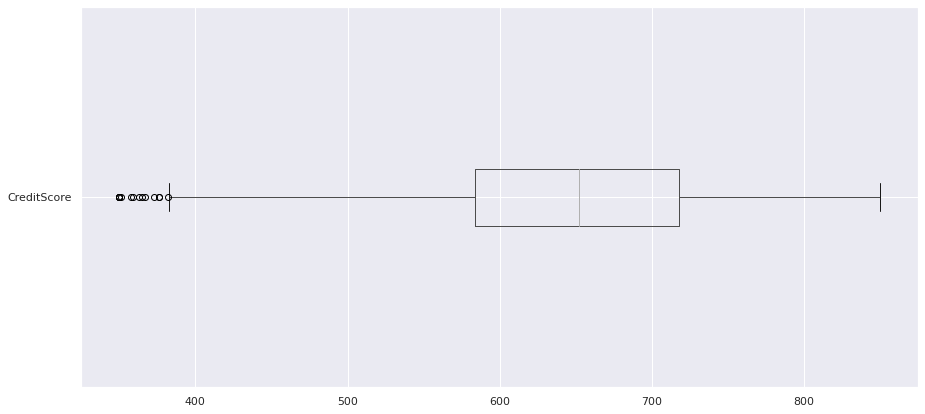

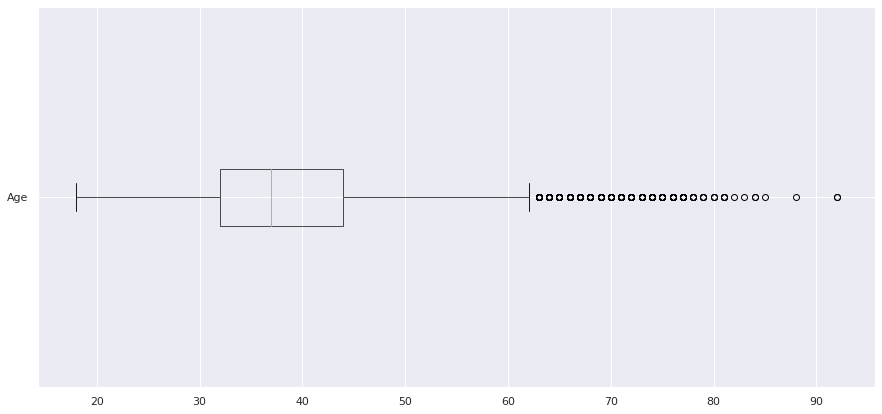

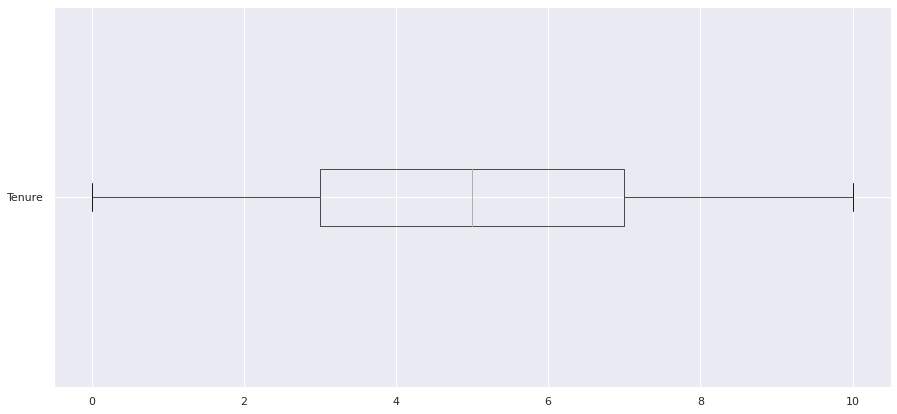

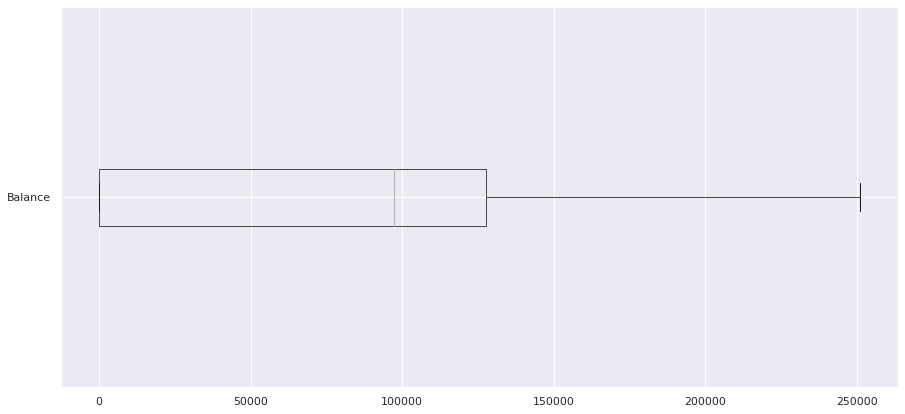

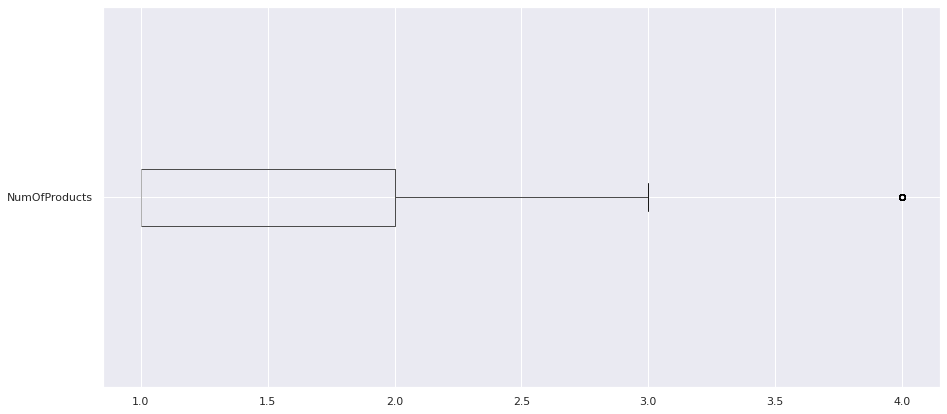

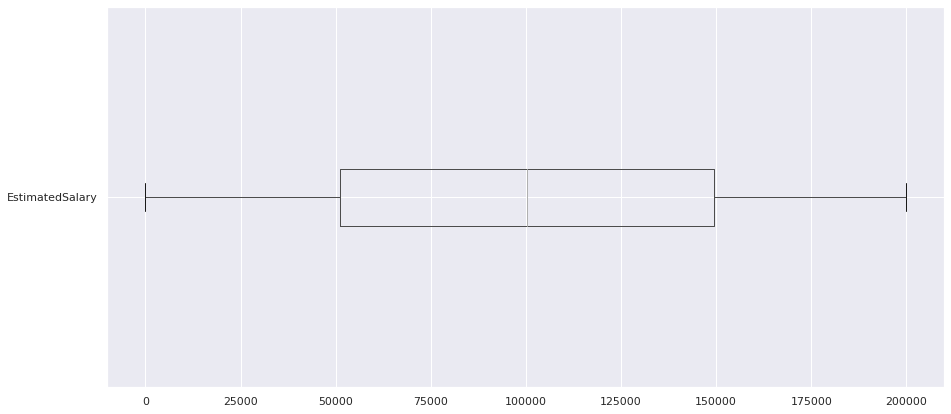

In [21]:
#Проверим численные признаки на выбросы
cols_numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
for column in cols_numeric:
    df.boxplot(column=column, vert=False)
    plt.show()
    

Дубликатов и выбросов, с которыми надо бороться, нет!

In [22]:
#Проведем One Hot Encoding для текстовых признаков (Geography, Gender)
data_ohe = pd.get_dummies(df, drop_first=True)

In [23]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


<b>Вывод по пункту 1</b>
<br/>
<br/>
В этом пункте мы:
- Загрузили необходимые библиотеки; 
- Загрузили данные; 
- Проверили данные на линейную зависимость, выбросы, дубликаты; 
- Удалили null;
- Скорректировали типы данных;
- Провели кодирование текстовых признаков;


## Исследование задачи

В условиях задачи сказано про дисбаланс классов. Проверим объемы в наших данных.

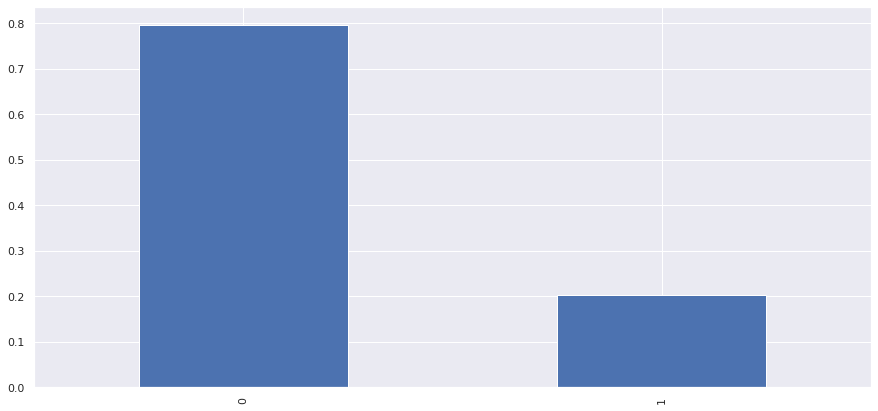

In [24]:
data_ohe.Exited.value_counts(normalize=True).plot(kind='bar');

С классом 1 - покинувшие - 20%, налицо сильный дисбаланс классов.<br/>
Сначала обучим модель без учета дисбаланса, как есть.

In [25]:
#Выделим X, y
X = data_ohe.drop(['Exited'], axis=1)
y = data_ohe['Exited'] 

In [26]:
#Разделим на Train и Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

In [27]:
X_train.shape, X_test.shape

((8000, 11), (2000, 11))

In [28]:
pd.options.mode.chained_assignment = None

In [29]:
#Стандартизируем численные признаки:
scaler = StandardScaler()
scaler.fit(X_train[cols_numeric])
X_train[cols_numeric] = scaler.transform(X_train[cols_numeric])
X_test[cols_numeric] = scaler.transform(X_test[cols_numeric])


In [31]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
params = {'n_estimators': range(10, 70), 'max_depth': range(5, 11, 1)}
scoring = ['f1', 'roc_auc']
grid = GridSearchCV(model, params, cv=5, scoring=scoring, refit='f1')
grid.fit(X_train, y_train)
clf = grid.best_estimator_
print(grid.best_params_)
metrics_columns = [f'mean_test_{x}' for x in scoring]
final_metrics = pd.DataFrame(grid.cv_results_)[metrics_columns].iloc[grid.best_index_]
print(final_metrics)


0.5622435117911478
{'max_depth': 9, 'n_estimators': 13}
mean_test_f1         0.562244
mean_test_roc_auc    0.853798
Name: 447, dtype: float64


## Борьба с дисбалансом

В этом разделе будем бороться с дисбалансом классов.<br/>
Первое, что будем пробовать - взвешивание классов.

In [35]:
#Как и до этого комментирую всю работу GridSearchCV, оставляю лучшую модель
model_balanced = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
scoring = ['f1', 'roc_auc']
params = {'n_estimators': range(10, 121), 'max_depth': range(5, 11, 1)}
grid_balanced = GridSearchCV(model_balanced, params, cv=5, scoring=scoring, refit='f1')
grid_balanced.fit(X_train, y_train)
clf_balanced = grid_balanced.best_estimator_
print(grid_balanced.best_params_)
metrics_columns_balanced = [f'mean_test_{x}' for x in scoring]
final_metrics_balanced = pd.DataFrame(grid_balanced.cv_results_)[metrics_columns_balanced].iloc[grid_balanced.best_index_]
print(final_metrics_balanced)

{'max_depth': 8, 'n_estimators': 74}
mean_test_f1         0.615031
mean_test_roc_auc    0.856821
Name: 397, dtype: float64


f1-мера при взвешенных классах уже 0.61! добавление одного параметра (class_weight='balanced') в обучаемую модель заметно улучшило ее! Эта модель уже проходит требуемый порог. ROC-AUC, однако, изменился не очень сильно.

Следующий метод борьбы с дисбалансом классов - Upsampling.

In [37]:
#Создадим функцию, которая будет выполнять upsampling.
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

In [38]:
X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 4)

In [39]:
model_upsampled = RandomForestClassifier(random_state=RANDOM_STATE)
params = {'n_estimators': range(10, 121), 'max_depth': range(5, 11, 1)}
scoring = ['f1', 'roc_auc']
grid_upsampled = GridSearchCV(model_upsampled, params, cv=5, scoring=scoring, refit='f1')
grid_upsampled.fit(X_train_upsampled, y_train_upsampled)
clf_upsampled = grid_upsampled.best_estimator_
print(grid_upsampled.best_params_)

metrics_columns_upsampled = [f'mean_test_{x}' for x in scoring]
final_metrics_upsampled = pd.DataFrame(grid_upsampled.cv_results_)[metrics_columns_upsampled].iloc[grid_upsampled.best_index_]
print(final_metrics_upsampled)

{'max_depth': 10, 'n_estimators': 69}
mean_test_f1         0.855907
mean_test_roc_auc    0.935007
Name: 614, dtype: float64


Значение f1-меры очень высоко здесь. ROC-AUC тоже очень высок.

Теперь для обработки дисбаланса воспользуемся библиотекой imblearn, методом SMOTE.

In [41]:
smote = SMOTE(random_state=RANDOM_STATE)
smote_x_train, smote_y_train = smote.fit_resample(X_train, y_train)

In [42]:
model_smote = RandomForestClassifier(random_state=RANDOM_STATE)
params = {'n_estimators': range(10, 121), 'max_depth': range(5, 11, 1)}
scoring = ['f1', 'roc_auc']
grid_smote = GridSearchCV(model, params, cv=5, scoring=scoring, refit='f1')
grid_smote.fit(smote_x_train, smote_y_train)
clf_smote = grid_smote.best_estimator_
print(grid_smote.best_params_)

metrics_columns_smote = [f'mean_test_{x}' for x in scoring]
final_metrics_smote = pd.DataFrame(grid_smote.cv_results_)[metrics_columns_smote].iloc[grid_smote.best_index_]
print(final_metrics_smote)

{'max_depth': 10, 'n_estimators': 107}
mean_test_f1         0.839287
mean_test_roc_auc    0.925399
Name: 652, dtype: float64


Метрики немного ниже, чем при upsampling, но совсем чуть-чтуь.

In [50]:
#Посмотрим таблицу финальных метрик
lst = [final_metrics_balanced, final_metrics_upsampled, final_metrics_smote]

df_metrics = pd.DataFrame(lst, index = ['weighting', 'upsampling', 'smote'])
df_metrics

,mean_test_f1,mean_test_roc_auc
weighting,0.615031,0.856821
upsampling,0.855907,0.935007
smote,0.839287,0.925399


Лучший F1 - при методе usampling

## Тестирование модели

Проверим на тестовой выборке нашу лучшую модель, ту, что обработали методом upsampling

In [51]:
y_predicted_upsampled = clf_upsampled.predict(X_test)
print("F1", f1_score(y_test, y_predicted_upsampled))

#ROC-AUC вероятности класса 1:
probabilities_valid = clf_upsampled.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_test,probabilities_one_valid)
print("ROC-AUC", auc_roc)

F1 0.6310160427807487
ROC-AUC 0.8672848503356978


<b>Вывод: Мы провели сначала обучение модели без учета дисбаланса классов, затем приняли его во внимание, исправили его с помощью взвешивания классов, upsampling и SMOTE. Во всех случаях результат существенно улучшился, превышен минимальный требуемый порог. После мы выбрали лучшую модель и применили ее на тестовой выборке. Необходимый порог превышен.</b>